#Harris Corner
In this example the Harris Corner Detector is implemented from the method discussed in the lessons.

> Corners are detected in local image regions using the corner reponse function $R=Det(M)-\alpha Trace(M)$ which is formed from the Determinate and Trace of the matrix $ M = \begin{vmatrix} A & B \\ C & D \end{vmatrix}$. M is referred to as the second moment matrix (slide 11).

> The second moment matrix nominally consists of the 2nd order partial derivatives of change in intensity of the image e.g. $A = \frac{\partial^2{E_{0,0}}}{\partial{x}^2}$.

> The 2nd order partial derivatives can be approximated from products of partial derivatives of the image convolved with a small gaussian window $\frac{\partial^2{E_{0,0}}}{\partial{x}^2} = \sum_{u,v} 2 w_{u,v} (\frac{\partial{I_{u,v}}}{\partial{x}}\frac{\partial{I_{u,v}}}{\partial{x}} )= X^2\circledast W$ . (slide 9)

> The first order image derivatives can be obtained using any finite difference approximate to the derivative or with by filtering the image with the x and y sobel kernels $\frac{\partial{I_{u,v}}}{\partial{x}}= X=I_{u,v}\circledast x_{sobel}$ (slide 7)






**HouseKeeping:** Load test image, import required packages (you can swap between the checkerboard test image, which is very useful to determine that the algorithm works properly and other images)

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request

In [2]:
# function to read images from Web addresses.
def url_to_image(url):
	user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
	headers ={'User-Agent':user_agent,}
	request=urllib.request.Request(url,None,headers)
	resp = urllib.request.urlopen(request)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

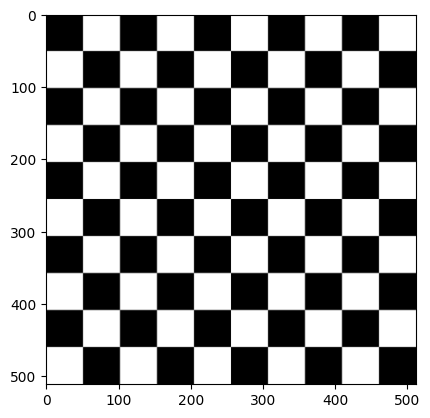

In [3]:
# Import and resize corner regions.
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/10x10_checkered_board.svg/800px-10x10_checkered_board.svg.png"
#image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Canberra_%28AU%29%2C_Letter_Boxes_at_Kendall_Lane_--_2019_--_1829.jpg/1920px-Canberra_%28AU%29%2C_Letter_Boxes_at_Kendall_Lane_--_2019_--_1829.jpg"
image = url_to_image(image_url)

# Rescale & Crop Image
HW_trg =512
img_H = np.shape(image)[0]
img_W = np.shape(image)[1]
min_dim_size = min(img_H,img_W)
scale_fac = HW_trg/min_dim_size
scale_img_H = int(np.ceil(np.shape(image)[0]*scale_fac))
scale_img_W = int(np.ceil(np.shape(image)[1]*scale_fac))
rescale_image = cv2.resize(image, (scale_img_W,scale_img_H), interpolation = cv2.INTER_AREA)
#rotate_image = cv2.rotate(rescale_image, cv2.ROTATE_90_CLOCKWISE)
crop_image = rescale_image[0:HW_trg, 0:HW_trg]
gray = cv2.cvtColor(crop_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,'gray')

#Harris Algorithm (part 1)
In order to be able to form the components of the matrix M we will carry out the following steps:

1.   Calculate Sobel Filter Kernels & (small) Gaussian kernel.
2.   Determine estimates of 1st order partial derivatives of the image $(\frac{\partial{I_{u,v}}}{\partial{x}},\frac{\partial{I_{u,v}}}{\partial{y}})$ by convolving the image with the sobel kernels.
3.    Obtain products of 1st order partial derivatives (e.g. $XY= \frac{\partial{I_{u,v}}}{\partial{x}} \frac{\partial{I_{u,v}}}{\partial{y}}$) and convolve them with the guassian kernel to obtain components of M (e.g. $ A = X^2 \circledast W$).  


In [4]:
#Create function to obtain sobel filtered image (with x,y sobel kernels)
#Create function to obtain gaussian kernel

def sobel_filter(gray):
   sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)  # x kernel
   sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)  # y kernel
   sobel_mag = np.sqrt(sobelx**2+sobely**2)
   sobel_mag = sobel_mag/np.max(sobel_mag)
   return [sobelx,sobely,sobel_mag]

def gauss_kernel(sigma):
    # kernel size Must be approximately 6 x sigma and an odd number
    k_size = int(6*sigma+1)
    rng = (k_size-1)//2
    x = np.arange(-rng,rng+1)
    gauss_kernel = (np.exp((-x**2)/(2*sigma**2)))/(np.sqrt(2*np.pi)*(sigma))
    gauss_2d_kernel = np.outer(gauss_kernel,gauss_kernel)
    return gauss_2d_kernel


In [5]:
# Obtain estimates of parital derivatives of the image by convolution with sobel kernels
derv_x,dev_y,sobel_mag = sobel_filter(gray)


In [6]:
# Obtain products of 1st order partial derivatives
Xsq = np.multiply(derv_x, derv_x)
Ysq = np.multiply(dev_y, dev_y)
XY = np.multiply(derv_x, dev_y)

# Determine Gaussian Kernel.
sigma =2
gauss_2d_kernel = gauss_kernel(sigma)

#Convolve Products with Gaussian Kernel
Xsq=signal.convolve2d(Xsq, gauss_2d_kernel, boundary='symm', mode='same')
Ysq=signal.convolve2d(Ysq, gauss_2d_kernel, boundary='symm', mode='same')
XY=signal.convolve2d(XY, gauss_2d_kernel, boundary='symm', mode='same')

#Harris Algorithm (part2)
In this second part the components $A,B,C,D$ of the matrix $M$ are calculated from the previous section. The corner response function is determined pixel wise across the image.

In [7]:
#Get corner response using linear algebra
alpha = 0.04
response_fun = np.zeros((HW_trg,HW_trg))

for u in range(0,HW_trg):
    for v in range(0,HW_trg):
        # Calculate compents in region
        A=np.sum(np.sum(Xsq[u,v]))
        B=np.sum(np.sum(Ysq[u,v]))
        C=np.sum(np.sum(XY[u,v]))
        M = [[A,C],[C,B]]
        # Have components so don't need to explicitly calculate
        R = np.linalg.det(M)-alpha*np.trace(M)**2
        # Assign R to region
        response_fun[u:,v] = R



#Plot Corner response & Mark corners.

In this final section we can plot the results from the Harris algorithm.



1.   As the corner response function is obtained at every point in the image, the corner response can be displayed as an image itself. (A normalised false color plot is displayed)
2.   In order to find and mark corners a threshold value is used to remove the flat regions and edges found in the corner response. A black and white plot of points above threshold is obtained.
3.   The coordinates of local maxima in the image are obtained using the procedure in https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html The coordinates can be marked on the image.

Note that the Harris corner algorithm is not scale invariant and only responds to corners at one scale, which is set by the size of the gaussian window we use in the algorithm. Typically this is set to a small value and fine corner features are found as is done in this notebook.




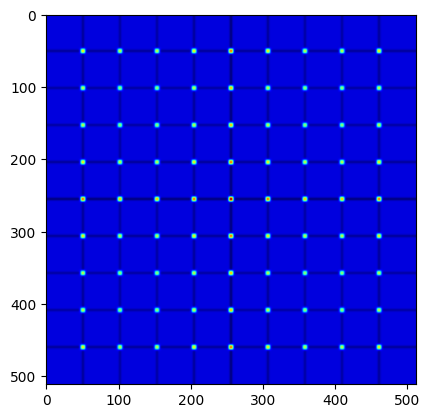

In [8]:
# Plot response function

norm_response = response_fun+abs(np.min(response_fun))
norm_response = 255.0*norm_response/np.max(norm_response)
plt.imshow(norm_response,'jet')

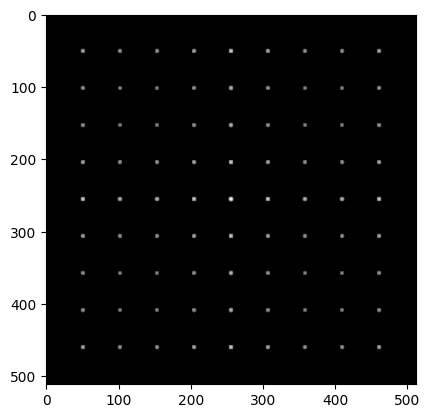

In [9]:
#Take large values only
vals_greater_thresh = np.multiply((norm_response>80),norm_response)
#t_val,vals_greater_thresh = cv2.threshold(norm_response,80,255,cv2.THRESH_BINARY)
plt.imshow(vals_greater_thresh,'gray')

In [10]:
# Find local maximum
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage import data, img_as_float
image_max = ndi.maximum_filter(vals_greater_thresh, size=4, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(vals_greater_thresh, min_distance=5)

for xy_pos in coordinates:
   cv2.circle(crop_image, (xy_pos[1],xy_pos[0]), 1, (255,0,0),thickness=2)


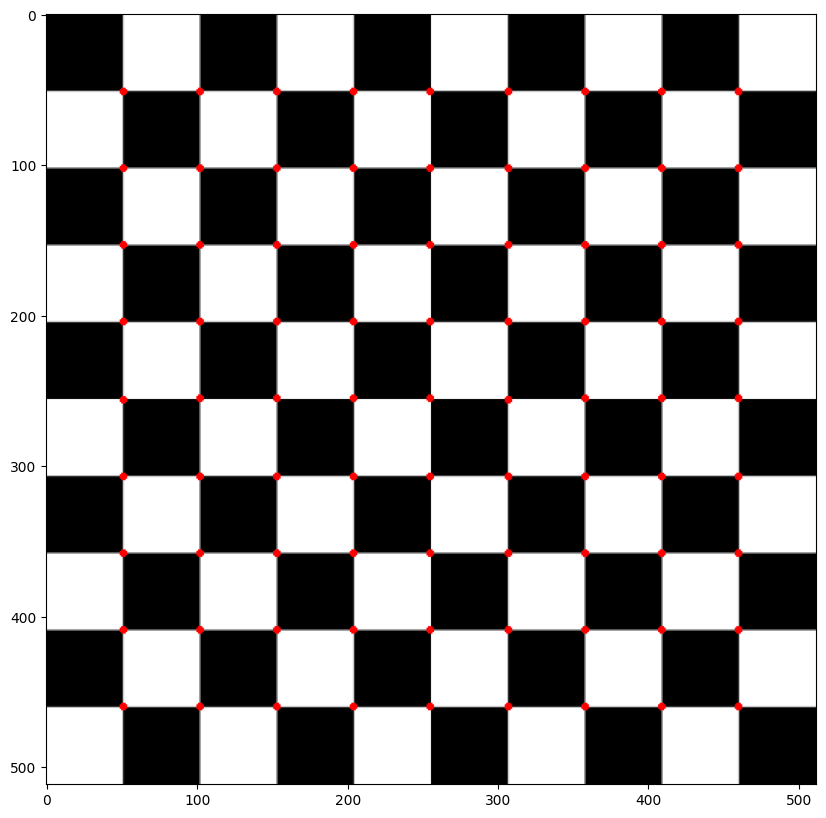

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(crop_image)